# **Data Import :**

In [ ]:
!pip install rasterio --quiet

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rasterio
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WaterSeg_Data.zip to WaterSeg_Data (1).zip


In [ ]:
import zipfile
import os

# مسار الملف المضغوط (تأكد أنك رفعته)
zip_path = "/content/WaterSeg_Data.zip"
extract_dir = "/content/WaterSeg_Data"

# فك الضغط
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# التأكد من المحتويات
os.listdir(f"{extract_dir}/data")



['images', 'labels']

# **Preprocessing :**

In [ ]:
image_dir = "/content/WaterSeg_Data/data/images"
label_dir = "/content/WaterSeg_Data/data/labels"

# أسماء الملفات المشتركة
image_names = [f[:-4] for f in os.listdir(image_dir) if f.endswith(".tif")]
label_names = [f[:-4] for f in os.listdir(label_dir) if f.endswith(".png")]
common_names = sorted(list(set(image_names) & set(label_names)))

# قراءة صورة .tif (12 قناة)
def read_tif_image(path):
    with rasterio.open(path) as img:
        arr = img.read()  # (channels, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # إلى (H, W, C)
        arr = cv2.resize(arr, (128, 128))
    return arr

# قراءة لابل .png
def read_label(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# تحميل البيانات
image_paths = [os.path.join(image_dir, name + ".tif") for name in common_names]
label_paths = [os.path.join(label_dir, name + ".png") for name in common_names]

images = [read_tif_image(p) for p in image_paths]
labels = [read_label(p) for p in label_paths]

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.uint8)

print("X shape:", X.shape)  # (N, 128, 128, 12)
print("Y shape:", Y.shape)  # (N, 128, 128, 1)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


In [ ]:
# تطبيع الصور [0, 1]
X = X / 255.0

# تحويل اللابل إلى 0 و 1 فقط (للتأكد)
Y = (Y > 0).astype(np.uint8)

# تحويل إلى one-hot (لـ 2 كلاس)
Y = to_categorical(Y, num_classes=2)


In [ ]:
# 70% تدريب - 15% تحقق - 15% اختبار
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.15, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1765, random_state=42)

print("Train:", train_x.shape)
print("Val:", val_x.shape)
print("Test:", test_x.shape)


Train: (214, 128, 128, 12)
Val: (46, 128, 128, 12)
Test: (46, 128, 128, 12)


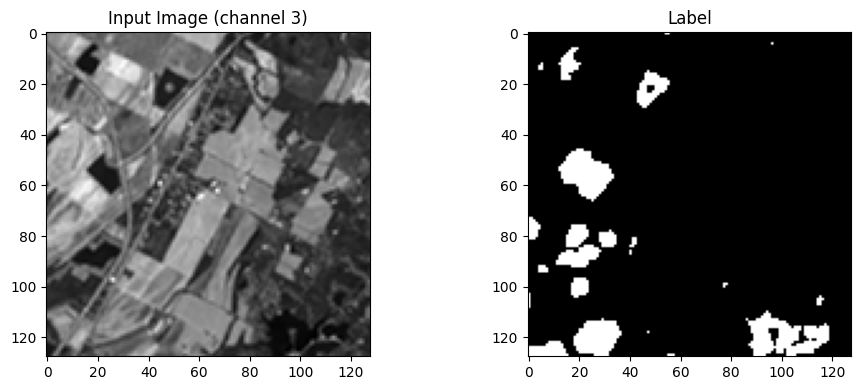

In [ ]:
def show_sample(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(train_x[index][:,:,3], cmap='gray')  # مثال: عرض القناة رقم 3
    axs[0].set_title("Input Image (channel 3)")
    axs[1].imshow(np.argmax(train_y[index], axis=-1), cmap='gray')
    axs[1].set_title("Label")
    plt.tight_layout()
    plt.show()

show_sample(0)


# **U-Net Model :**

In [ ]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, filters):
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    # Bridge
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    # Output
    outputs = layers.Conv2D(2, 1, activation="softmax")(d3)

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_146[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 64, 64,    │          0 │ conv2d_147[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_29… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_148[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 32, 32,    │          0 │ conv2d_149[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_30… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_150[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 16, 16,    │          0 │ conv2d_151[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_31… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_152[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_29    │ (None, 32, 32,    │          0 │ conv2d_153[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_29      │ (None, 32, 32,    │          0 │ up_sampling2d_29… │
│ (Concatenate)       │ 768)              │            │ conv2d_151[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 32, 32,    │  1,769,728 │ concatenate_29[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_154[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_30    │ (None, 64, 64,    │          0 │ conv2d_155[0][0]

 Total params: 7,788,162 (29.71 MB)

 Trainable params: 7,788,162 (29.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping and reduce_lr & model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint = ModelCheckpoint("best_model_scratch.h5", monitor="val_accuracy", save_best_only=True)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=50,
    batch_size=8
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - accuracy: 0.9065 - loss: 0.2318 - val_accuracy: 0.9256 - val_loss: 0.2000
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9092 - loss: 0.2190 - val_accuracy: 0.9257 - val_loss: 0.1987
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9159 - loss: 0.2150 - val_accuracy: 0.9253 - val_loss: 0.2003
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9169 - loss: 0.2059 - val_accuracy: 0.9256 - val_loss: 0.1969
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9024 - loss: 0.2223 - val_accuracy: 0.9257 - val_loss: 0.1943
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9147 - loss: 0.2096 - val_accuracy: 0.9260 - val_loss: 0.1944
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9125 - loss: 0.2106 - val_accuracy: 0.9265 - val_loss: 0.1907
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9074 - loss: 0.2210 - val_accuracy: 0.92

In [ ]:
loss, acc = model.evaluate(train_x, train_y)
print("Train accuracy:", acc)

loss, acc = model.evaluate(test_x, test_y)
print("Test accuracy:", acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.9633 - loss: 0.0868
Train accuracy: 0.9673174023628235
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - accuracy: 0.9645 - loss: 0.1028
Test accuracy: 0.9641856551170349


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


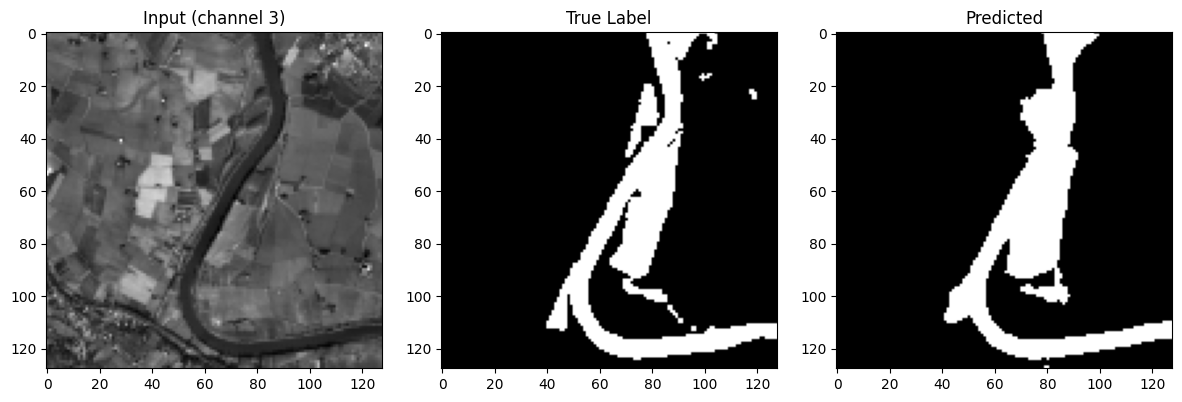

In [ ]:
def show_prediction(index):
    image = test_x[index:index+1]
    label = np.argmax(test_y[index], axis=-1)

    pred = model.predict(image)[0]
    pred = np.argmax(pred, axis=-1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[0][:,:,3], cmap='gray')  # قناة واحدة فقط
    axs[0].set_title("Input (channel 3)")
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title("True Label")
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title("Predicted")
    plt.tight_layout()
    plt.show()

show_prediction(0)


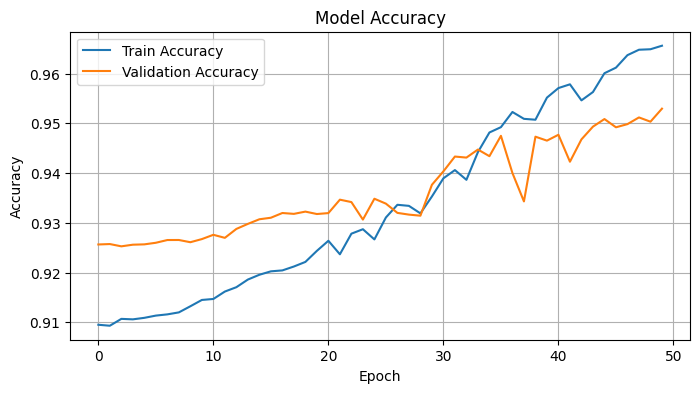

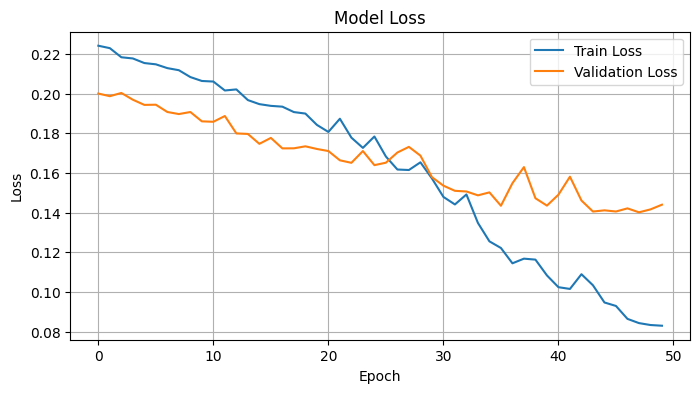

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# الحصول على التنبؤات من النموذج
y_pred_probs = model.predict(test_x)
y_pred = np.argmax(y_pred_probs, axis=-1)   # شكل: (N, 128, 128)
y_true = np.argmax(test_y, axis=-1)          # تحويل One-hot إلى تصنيف رقمي

# تحويل الأبعاد إلى متجهات 1D للمقارنة (بكسل ببكسل)
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# عرض تقرير التصنيف
print("\nClassification Report:\n", classification_report(y_true_flat, y_pred_flat, digits=4))

# حساب الدقة والمقاييس الأخرى
precision = precision_score(y_true_flat, y_pred_flat, average='binary')
recall = recall_score(y_true_flat, y_pred_flat, average='binary')
f1 = f1_score(y_true_flat, y_pred_flat, average='binary')
accuracy = accuracy_score(y_true_flat, y_pred_flat)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 914ms/step

Classification Report:
               precision    recall  f1-score   support

           0     0.9734    0.9817    0.9775    597417
           1     0.9276    0.8973    0.9122    156247

    accuracy                         0.9642    753664
   macro avg     0.9505    0.9395    0.9448    753664
weighted avg     0.9639    0.9642    0.9640    753664

Accuracy:  0.9642
Precision: 0.9276
Recall:    0.8973
F1 Score:  0.9122
